# Sobre o desafio

"Novexus, uma empresa de telecomunicações líder no mercado, está comprometida em reter seus clientes. Para isso, contratou uma equipe de cientistas de dados para identificar os clientes com maior propensão a abandoná-la.

A primeira etapa do projeto será a limpeza e análise exploratória dos dados, para identificar padrões e tendências que podem ajudar a identificar esses clientes. Após essa fase, os cientistas de dados desenvolverão modelos de classificação para identificar os clientes com maior probabilidade de cancelar os serviços.

Ao identificar esses clientes, a Novexus poderá tomar medidas para retê-los."

# Baixando o banco de dados

In [ ]:
# Biblioteca a serem usadas

import pandas as pd
from pandas import json_normalize
import numpy as np
import json

In [ ]:
# Carregar os dados a partir do arquivo JSON

with open('/content/drive/MyDrive/Alura/dados/Telco-Customer-Churn.json') as json_file:
    data = json.load(json_file)

# Transformar os dados em um DataFrame do Pandas

df = pd.json_normalize(data)

In [ ]:
# Visualizar as primeiras linhas do DataFrame
df.head()

# Valores únicos e análise da tipagem dos dados

In [ ]:
def valores_unicos_e_tipagem(df):
    for col in df.columns:
        if df[col].nunique() > 4:
            print(f'# Coluna {df[col].dtypes}: {col} - Existem {df[col].nunique()}/{len(df[col])} valores únicos')
        else:
            print(f'# Coluna {df[col].dtypes}: {col}', df[col].unique())

valores_unicos_e_tipagem(df)

### **Analise Preliminar**

* Temos um total de 7267 clientes na base de dados;
* Se obseva uma quantidade de valores faltantes na coluna focal de Churn que precisa ser avaliada para resolver a questão.

In [ ]:
#Viisualizar as colunas categoricas.
df.describe(include='object')

In [ ]:
# Quantos dados estão nulos na coluna alvo (Churn)

n_faltantes = df[df['Churn'] == ''].shape[0]
porcentagem_n_faltantes = round((n_faltantes / len(df)) * 100, 2)

f'Existem um total de {n_faltantes} dados faltantes na coluna Churn. Isso representa {porcentagem_n_faltantes}% do total de clientes.'

'Existem 224 dados faltantes na coluna Churn. Isso representa 3.08% do total'

In [ ]:
# Vamos analisar a coluna Charges.Total e transformá-la para valores numéricos:

list(df['account.Charges.Total'].head())

['593.3', '542.4', '280.85', '1237.85', '267.4']

In [ ]:
# Existem dados(df) faltantes, por isso errors = 'coerce'

df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors = 'coerce')

In [ ]:
df.info()

# Procurando incosistências nos dados, foco a coluna Churn


# Corrigir as inconsistências nos dados

In [ ]:
df_completos = df.copy().loc[~(df['Churn'] == '')].reset_index(drop = True)

In [ ]:
df_completos[df_completos['account.Charges.Total'].isnull()][['customer.tenure',
                                                              'account.Contract',
                                                              'account.Charges.Monthly',
                                                              'account.Charges.Total']]

In [ ]:
indice_dados_faltantes = df_completos[
    df_completos['account.Charges.Total'].isnull()].index


def gasto_total(linha):
    if linha['account.Contract'] == 'Two year':
        linha['account.Charges.Total'] = linha['account.Charges.Monthly'] * 24
        linha['customer.tenure'] = 24
    else:
        linha['account.Charges.Total'] = linha['account.Charges.Monthly'] * 12
        linha['customer.tenure'] = 12
    return linha


dados_clean = df_completos.copy()
dados_clean.loc[indice_dados_faltantes] = dados_clean.loc[
    indice_dados_faltantes].apply(gasto_total, axis=1)

# Visualização gráfica

In [ ]:
# Paleta de Cores a ser usado no gráfico

paleta_cores = ['#1E1E2E', '#48A24E', '#FF7F50', '#E53935', '#9B59B6']

In [ ]:
# Bibliotecas para gerar gráficos para analises visual

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [ ]:
# Visualizar a distribuição de frequência de diferentes grupos em um conjunto de dados

def plot_countplots(data, coluna_hue, grupos, figsize=(12, 8)):
    num_grupos = len(grupos)
    cols = 2
    linhas = int(np.ceil(num_grupos / cols))

    fig, axes = plt.subplots(nrows=linhas, ncols=cols, figsize=figsize)
    axes = axes.flatten()  # Transforma a matriz de eixos em uma matriz 1D

    for i, grupo in enumerate(grupos):
        if i < num_grupos:
            eixo = axes[i]  # Acessa o eixo diretamente da matriz 1D
            sns.countplot(x=grupo,
                          data=data,
                          hue=coluna_hue,
                          palette=paleta_cores,
                          alpha=0.8,
                          ax=eixo)
            sns.despine(right=True, top=True)
            eixo.legend([], [], frameon=False)
            eixo.set_xlabel(grupo.split('.')[-1])
            eixo.set_ylabel('Frequência')

    # Remove quaisquer subplots vazios adicionais

    for i in range(num_grupos, linhas * cols):
        fig.delaxes(axes[i])

    # Cria uma legenda fora dos subplots

    handles, labels = eixo.get_legend_handles_labels()
    legenda = fig.legend(handles,
                         labels,
                         loc='upper center',
                         bbox_to_anchor=(0.5, 1.13),
                         ncol=2)
    legenda.set_title('Churn')

    plt.tight_layout()

In [ ]:
# Criando base para analise estatistica

def adicionar_estatisticas(ax, dados, metrica, texto_y, cor):
    valores_estatisticos = dados.groupby('Churn')[metrica].agg(['mean', 'median', 'min', 'max'])

    texto = f'Média: {valores_estatisticos["mean"][0]:.2f} | {valores_estatisticos["mean"][1]:.2f}\n'
    texto += f'Mediana: {valores_estatisticos["median"][0]:.2f} | {valores_estatisticos["median"][1]:.2f}\n'
    texto += f'Mínimo: {valores_estatisticos["min"][0]:.2f} | {valores_estatisticos["min"][1]:.2f}\n'
    texto += f'Máximo: {valores_estatisticos["max"][0]:.2f} | {valores_estatisticos["max"][1]:.2f}'

    ax.text(0.5, texto_y, texto, transform=ax.transAxes, fontsize=12, color=cor, ha='center')

In [ ]:
# Histogramas

num_columns = df_completos.select_dtypes(include=['int64', 'float64']).columns

for col in num_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, bins=30)
    plt.title(f'Histograma de {col}')
    plt.show()

##  Visualizando a coluna Churn

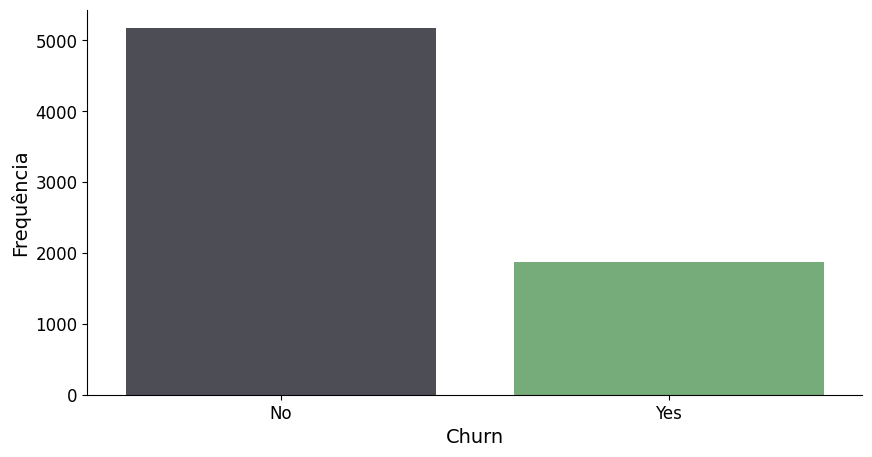

In [ ]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Churn', data=dados_clean, palette=paleta_cores, alpha=.8)
sns.despine(right=True, top=True)

plt.ylabel('Frequência')
plt.show()

In [ ]:
# Contagem de valores de Churn
contagem_churn = dados_clean['Churn'].value_counts()
contagem_churn

No     5174
Yes    1869
Name: Churn, dtype: int64

In [ ]:
# Valores em percentual de Churn
dados_clean['Churn'].value_counts(normalize=True).mul(100).round(2).astype(str) + ' %'


No     73.46%
Yes    26.54%
Name: Churn, dtype: object

**Análise preliminar**: Observamos que a maioria esmagadora de nossos clientes, cerca de 73,46%, optou por não cancelar nossos serviços, enquanto apenas 26,54% cancelaram. Desta forma temos um desequilíbrio nos dados, o que significa que qualquer análise ou previsão que fizermos tende a favorecer os clientes que continuam conosco

In [ ]:
# Substituir os valores vazios na coluna 'Churn' por um valor padrão (por exemplo, 'Unknown')
df_completos['Churn'].replace('', 'Unknown', inplace=True)

# Gráficos de contagem após correção
plt.figure(figsize=(8, 4))
sns.countplot(data=df_completos, x='Churn')
plt.title('Gráfico de Contagem de Churn após Correção')
plt.xticks(rotation=45)
plt.show()

# Exibir as primeiras linhas do DataFrame após correção
df_completos.head()

In [ ]:
# Contagem de homens e mulheres
contagem_genero = df_completos['customer.gender'].value_counts()

# Exibir a contagem
contagem_genero

Male      3555
Female    3488
Name: customer.gender, dtype: int64

## Quantidade de churn por gênero

In [ ]:
# Converter valores 'No' e 'Yes' da coluna 'Churn' para 0 e 1
df_completos['Churn'] = df_completos['Churn'].replace({'No': 0, 'Yes': 1})

# Calcular a quantidade de churn por gênero
quantidade_churn_por_genero = df_completos.groupby('customer.gender')['Churn'].sum()

print(quantidade_churn_por_genero)

customer.gender
Female    939
Male      930
Name: Churn, dtype: int64


Análise preliminar: A divisão entre homens e mulheres é próxima, com 930 e 939 cancelamentos, respectivamente. No entanto, é preciso analisar mais dados, como idade, localização e histórico de uso da internet, para ter uma compreensão mais profunda dessa diferença.

## Verificação das características categóricas (também conhecidas como variáveis categóricas ou atributos categóricos) e a variável de resposta "Churn"

**Informações das características dos CLIENTES em base ao Churn**

In [ ]:
# Criando primeiro conjunto de gráficos
grupo_1 = dados_clean.filter(like='customer').columns.tolist()[1:-1]

# Exibindo Gráfico
plot_countplots(df_completos, 'Churn', grupo_1)

**Análise preliminar** :

- A taxa de cancelamento é praticamente igual para homens e mulheres;
- O número de clientes idosos é baixo;
- Os clientes com parceiros têm menos probabilidade de cancelar;
- Os clientes sem dependentes têm uma taxa de cancelamento maior.

**Informações das características dos SERVIÇOS TELEFÔNICOS em base ao Churn**

In [ ]:
# Criando segundo conjunto de gráficos
grupo_2 = dados_clean.filter(like='phone').columns.tolist()

# Exibindo o gráfico
plot_countplots(dados_clean, 'Churn', grupo_2, figsize=(12, 5))

**Análise preliminar**: A taxa de retenção de clientes para o serviço de telefone é maior do que a taxa de cancelamento, mesmo para clientes sem serviço telefônico. A taxa de cancelamento é a mesma para clientes com uma ou várias linhas.

## Informações das características dos SERVIÇOS DE INTERNET

In [ ]:
# Criando segundo conjunto de gráficos
grupo_3 = dados_clean.filter(like='internet').columns.tolist()

# Exibindo o gráfico
plot_countplots(dados_clean, 'Churn', grupo_3, figsize=(12, 8))

**Análise preliminar** : Os clientes mostraram uma preferência por serviços de internet via DSL, com um número menor de clientes optando por cabos de fibra ótica. As taxas de cancelamento de streaming de TV e streaming de filmes foram semelhantes, sugerindo que outros fatores, como preços ou qualidade do serviço, podem ter sido responsáveis por essas decisões.

Os serviços de segurança online, backup online, proteção de dispositivos e suporte técnico desempenham um papel fundamental na satisfação dos clientes. Uma quantidade significativa de clientes que não possuíam esses serviços decidiu deixar a Novexus.

## Informações das características dos Financeiros dos Clientes

In [ ]:
# Criando segundo conjunto de gráficos

grupo_4 = dados_clean.filter(like='account').columns.tolist()[:-2]

# Gerando os gráficos

plot_countplots(dados_clean, 'Churn', grupo_4, figsize=(13, 6))
plt.xticks(rotation=20)
plt.show()

**Análise preliminar** : Os contratos mensais têm uma alta taxa de cancelamento, provavelmente devido a clientes experimentando diferentes serviços, qualidade inconsistente ou problemas de pagamento com cheque eletrônico. A empresa precisa reconsiderar o uso do cheque eletrônico ou eliminá-lo

## Feature numéricas

In [ ]:
features_num = dados_clean.select_dtypes(exclude=['object']).iloc[:, 1:]  # Excluindo o SeniorCitizen
features_num.head()

<Figure size 640x480 with 0 Axes>

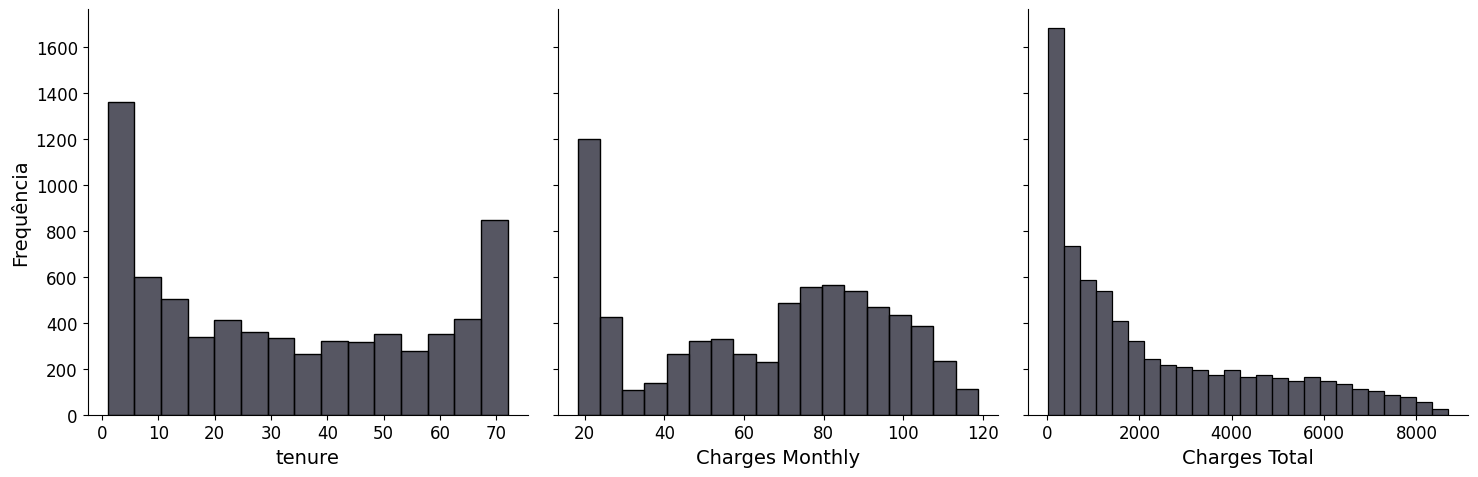

In [ ]:
# Adicione um título ao gráfico
plt.suptitle("Distribuição das Features Numéricas", fontsize=16)

fig, axes = plt.subplots(1, len(features_num.columns), figsize=(15, 5), sharey=True)

for i, col in enumerate(features_num.columns):
    sns.histplot(dados_clean[col], ax=axes[i], color=paleta_cores[0], kde=False)
    sns.despine(right=True, top=True)
    col_name = ' '.join(col.split('.')[1:])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequência')

    # Adicione rótulos nos eixos
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequência')

# Ajuste os limites dos eixos, se necessário
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)

# Adicione uma legenda, se necessário
# plt.legend(labels=['Label1', 'Label2', ...])

# Personalize as barras ou linhas, se necessário
# axes[i].plot(..., linewidth=2, linestyle='-', alpha=0.7)

# Adicione anotações, se necessário
# axes[i].annotate('Anotação', xy=(x, y), xytext=(x_text, y_text),
#                  arrowprops=dict(arrowstyle='->', lw=1.5))

plt.tight_layout()
plt.show()

# Boxplot para as variáveis numéricas

In [ ]:
dados_clean.select_dtypes(exclude = ['object']).head()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total
0,0,9,65.6,593.30
1,0,9,59.9,542.40
2,0,4,73.9,280.85
3,1,13,98.0,1237.85
4,1,3,83.9,267.40


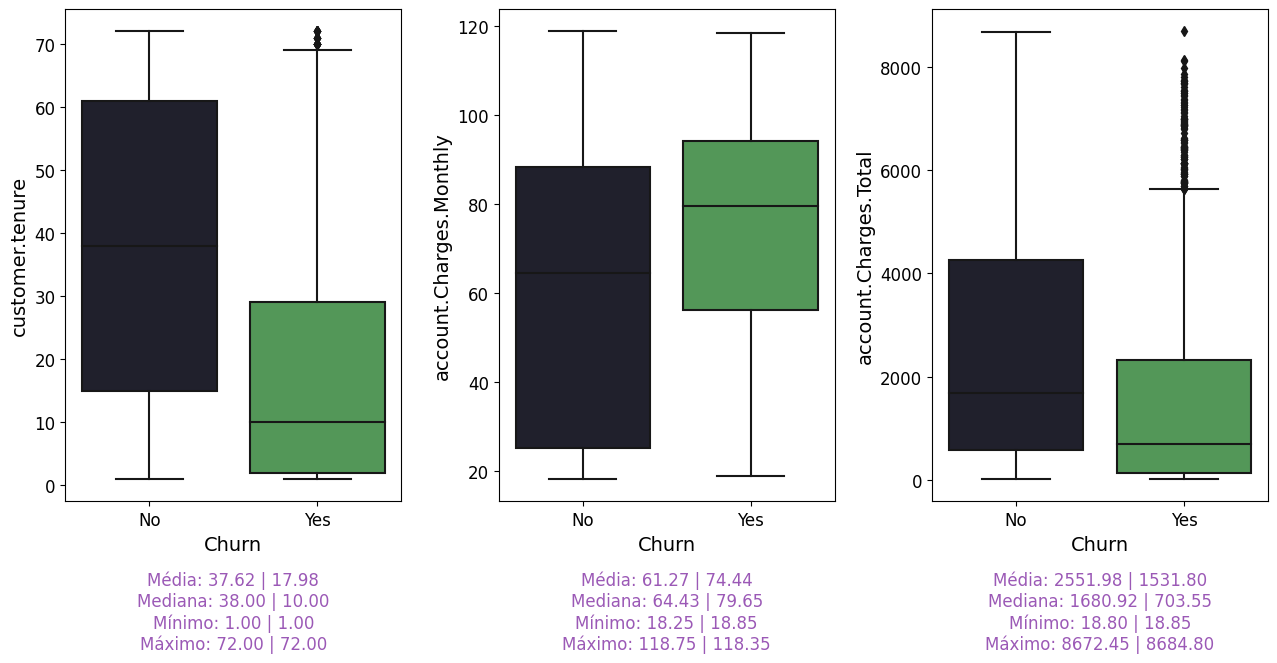

In [ ]:
fig, axes = plt.subplots(1, len(features_num.columns), figsize=(13, 7))

for i, col in enumerate(features_num.columns):
    boxplot = sns.boxplot(x='Churn', y=col, data=dados_clean, ax=axes[i], palette=paleta_cores)
    for patch in boxplot.artists:
        patch.set_alpha(.8)
    col_name = ' '.join(col.split('.')[1:])

    mediana = dados_clean.groupby('Churn')[col].median()
    media = dados_clean.groupby('Churn')[col].mean()
    minimo = dados_clean.groupby('Churn')[col].min()
    maximo = dados_clean.groupby('Churn')[col].max()

    adicionar_estatisticas(axes[i], dados_clean, col, -0.3, paleta_cores[-1])

plt.tight_layout()
plt.show()

**Análise preliminar** : Os clientes que permaneceram com a empresa tiveram, em média, contratos mais longos do que os que cancelaram. Por outro lado, os clientes que cancelaram tiveram, em média, gastos mensais mais elevados do que os que permaneceram. Isso pode ser devido a uma variedade de fatores, como diferentes tipos de serviços utilizados ou problemas de satisfação com a empresa.

Os clientes que cancelaram tiveram, em média, gastos totais mais baixos do que os que permaneceram. Isso sugere que, embora os clientes com despesas mais elevadas possam ser mais propensos a cancelar, eles podem não representar maior valor a longo prazo para a empresa